In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

from attacks import GM
from classifiers import CIFAR_CNN
from utils import save, unpickle, pixel_range, preprocess, hist_kde
from vae_gans import CIFAR_VAE_GAN

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

datadir = './CIFAR10_data/'
batches = [datadir + batch for batch in os.listdir(datadir)]


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
for i in tqdm(range(5)):
    batch = unpickle(batches[i])

    if i == 0:
        data = batch[b'data'].astype(np.float32)
        cifar = np.transpose(np.reshape(data, [-1, 3, 32, 32]), [0, 2, 3, 1])
        labels = batch[b'labels']
    else:
        data = batch[b'data'].astype(np.float32)
        cifar = np.concatenate((cifar, np.transpose(np.reshape(data, [-1, 3, 32, 32]), [0, 2, 3, 1])), axis=0)
        labels = np.concatenate((labels, batch[b'labels']), axis=0)

scaled_cifar = cifar / 127.5 - 1.0

test_batch = unpickle(batches[5])
cifar_test = np.transpose(np.reshape(test_batch[b'data'], [-1, 3, 32, 32]), [0, 2, 3, 1])
scaled_cifar_test = cifar_test / 127.5 - 1.0
labels_test = np.array(test_batch[b'labels'])

data_train = (scaled_cifar, labels)
data_test = (scaled_cifar_test, labels_test)

label_map = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


In [3]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = CIFAR_CNN('tf_logs/exp3/standard/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)),
                                                   logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r1 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = CIFAR_CNN('tf_logs/exp3/adv/GM/0.04_0.02_40_inf_xent/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)),
                                                   logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r2 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()

tf.reset_default_graph()

sess = tf.InteractiveSession()

DNN = CIFAR_CNN('tf_logs/exp3/adv/GM/1.6_2_40_2_xent/', activation=tf.nn.relu)
DNN.load(sess)

loss = -tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf.stop_gradient(tf.one_hot(DNN.yi, depth=DNN.n_classes)),
                                                   logits=DNN.logits)

loss_grad = tf.gradients(loss, DNN.X)[0]

r3 = preprocess(sess.run(loss_grad, feed_dict={DNN.X: data_test[0][:100]}), q1=0.5, q2=99.5)

sess.close()


INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model
INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.04_0.02_40_inf_xent/model
INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/1.6_2_40_2_xent/model


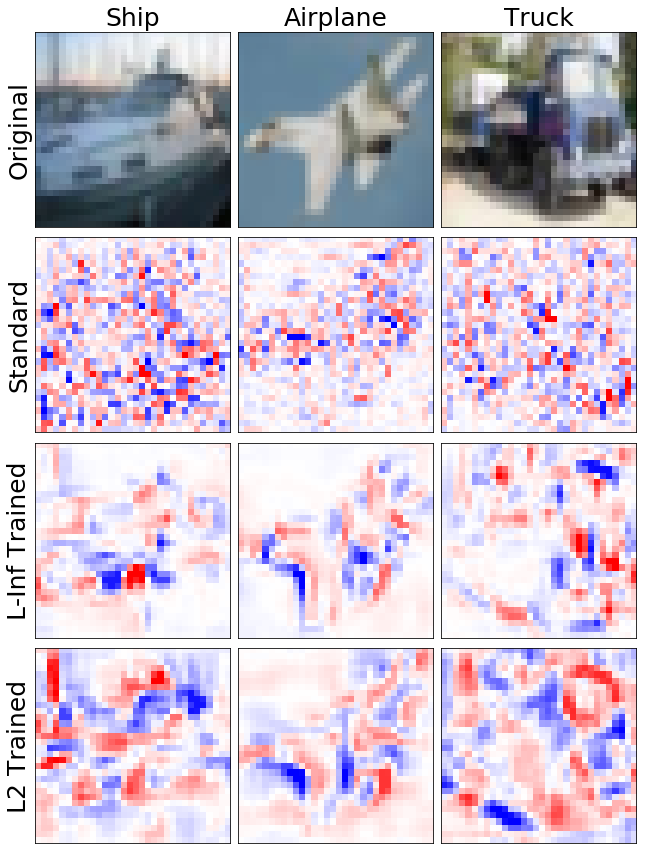

In [4]:
inds = [2, 10, 28]

plt.figure(figsize=(9, 12))

for i, ind in enumerate(inds):

    plt.subplot(4, 3, i + 1)
    plt.imshow((data_test[0][ind].reshape(32, 32, 3) + 1.0) * 0.5, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title(label_map[data_test[1][ind]], fontsize=25)
    if i == 0: plt.ylabel('Original', fontsize=25)

    plt.subplot(4, 3, 4 + i)
    v, _ = pixel_range(r1[ind])
    plt.imshow(r1[ind].reshape(32, 32), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('Standard', fontsize=25)

    plt.subplot(4, 3, 7 + i)
    v, _ = pixel_range(r2[ind])
    plt.imshow(r2[ind].reshape(32, 32), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('L-Inf Trained', fontsize=25)

    plt.subplot(4, 3, 10 + i)
    v, _ = pixel_range(r3[ind])
    plt.imshow(r3[ind].reshape(32, 32), vmin=v[0], vmax=v[1], cmap='bwr')
    plt.xticks([])
    plt.yticks([])
    if i == 0: plt.ylabel('L2 Trained', fontsize=25)

plt.tight_layout()
plt.subplots_adjust(wspace=0.04, hspace=0.04)

plt.savefig('figs/cifar10_loss_grad.jpg', bbox_inches='tight', dpi=300)

plt.show()

plt.close()


In [3]:
def evaluate(tf_logs, attack_params):
    datasets = []
    reconsts = []
    suc_inds = []
    l2_dists = []

    print('Generating Adversarial Attacks')

    for name, tf_log in tf_logs:

        if not tf_log:
            datasets.append((name, data_test[0]))
            continue

        tf.reset_default_graph()

        sess = tf.InteractiveSession()

        DNN = CIFAR_CNN(tf_log, activation=tf.nn.relu)
        DNN.load(sess)

        gm = GM(DNN, **attack_params)
        datasets.append((name, gm.attack(sess, data_test, batch_size=500)))

        sess.close()

    print('Generating Projections')

    tf.reset_default_graph()

    sess = tf.InteractiveSession()

    vae_gan = CIFAR_VAE_GAN('tf_logs/exp3/vae-gan/data_test/')
    vae_gan.load(sess)

    for name, dataset in datasets:
        reconsts.append((name, vae_gan.reconstruct(sess, (dataset, 0))))

    sess.close()

    print('Removing Unsuccessful Attacks')

    tf.reset_default_graph()

    sess = tf.InteractiveSession()

    DNN = CIFAR_CNN('tf_logs/exp3/standard/', activation=tf.nn.relu)
    DNN.load(sess)

    org_ys = DNN.inference(sess, data_test, batch_size=500)

    for name, dataset in datasets:

        adv_ys = DNN.inference(sess, (dataset, 0), batch_size=500)

        if name == 'Test Data':
            suc_inds.append(org_ys == adv_ys)
        else:
            suc_inds.append(org_ys != adv_ys)

    sess.close()

    print('Calculating L2 Distances')

    for i, ((name, dataset), (_, reconst)) in enumerate(zip(datasets, reconsts)):
        l2_dist = np.sqrt(np.sum(np.square(dataset[suc_inds[i]] - reconst[suc_inds[i]]), axis=(1, 2, 3)))
        l2_dists.append((name, l2_dist))

    return datasets, reconsts, l2_dists


In [68]:
tf_logs1 = [('Test Data', None),
            ('Standard', 'tf_logs/exp3/standard/'),
            ('L2 0.1 XEnt', 'tf_logs/exp3/adv/GM/0.1_2_40_2_xent/'),
            ('L2 0.4 XEnt', 'tf_logs/exp3/adv/GM/0.4_2_40_2_xent/'),
            ('L2 1.6 XEnt', 'tf_logs/exp3/adv/GM/1.6_2_40_2_xent/')
            ]

tf_logs2 = [('Test Data', None),
            ('Standard', 'tf_logs/exp3/standard/'),
            ('L2 0.1 CW', 'tf_logs/exp3/adv/GM/0.1_2_40_2_cw/'),
            ('L2 0.4 CW', 'tf_logs/exp3/adv/GM/0.4_2_40_2_cw/'),
            ('L2 1.6 CW', 'tf_logs/exp3/adv/GM/1.6_2_40_2_cw/')
            ]

tf_logs3 = [('Test Data', None),
            ('Standard', 'tf_logs/exp3/standard/'),
            ('L-Inf 0.005 XEnt', 'tf_logs/exp3/adv/GM/0.005_0.02_40_inf_xent/'),
            ('L-Inf 0.01 XEnt', 'tf_logs/exp3/adv/GM/0.01_0.02_40_inf_xent/'),
            ('L-Inf 0.02 XEnt', 'tf_logs/exp3/adv/GM/0.02_0.02_40_inf_xent/'),
            ]

tf_logs4 = [('Test Data', None),
            ('Standard', 'tf_logs/exp3/standard/'),
            ('L-Inf 0.005 CW', 'tf_logs/exp3/adv/GM/0.005_0.02_40_inf_cw/'),
            ('L-Inf 0.01 CW', 'tf_logs/exp3/adv/GM/0.01_0.02_40_inf_cw/'),
            ('L-Inf 0.02 CW', 'tf_logs/exp3/adv/GM/0.02_0.02_40_inf_cw/'),
            ]

# attack_params = {'eps': 5, 'step_size': 2, 'n_steps': 40, 'norm': '2', 'loss_type': 'xent'}
attack_params = {'eps': 12, 'step_size': 2, 'n_steps': 40, 'norm': '2', 'loss_type': 'cw'}

ress = []

for tf_logs in [tf_logs1, tf_logs2, tf_logs3, tf_logs4]:
    ress.append(evaluate(tf_logs, attack_params))

save(ress, 'results/gradient/exp3/results_{}.pickle'.format(attack_params['loss_type']))


Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.1_2_40_2_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.4_2_40_2_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/1.6_2_40_2_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp4/vae-gan/data_test/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.1_2_40_2_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.11it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.4_2_40_2_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/1.6_2_40_2_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp4/vae-gan/data_test/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.005_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.01_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.02_0.02_40_inf_xent/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp4/vae-gan/data_test/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model
Calculating L2 Distances
Generating Adversarial Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.005_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.01_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


INFO:tensorflow:Restoring parameters from tf_logs/exp4/adv/GM/0.02_0.02_40_inf_cw/model


100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


Generating Projections
INFO:tensorflow:Restoring parameters from tf_logs/exp4/vae-gan/data_test/model
Removing Unsuccessful Attacks
INFO:tensorflow:Restoring parameters from tf_logs/exp4/standard/model
Calculating L2 Distances


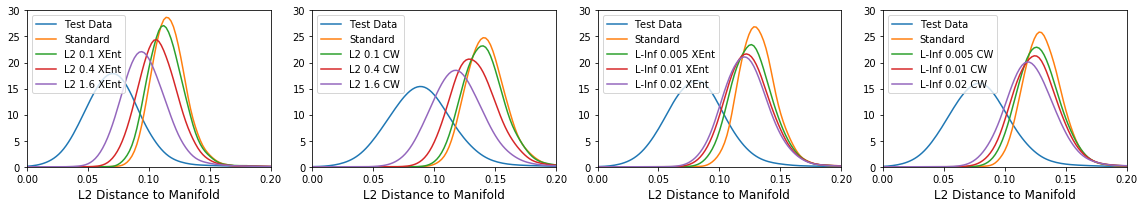

In [2]:
ress = unpickle('results/gradient/exp3/results_xent.pickle')

plt.figure(figsize=(16, 3))

for i, res in enumerate(ress):

    plt.subplot(1, 4, i + 1)

    for j, (name, l2_dist) in enumerate(res[2]):

        if name == 'Test Data':
            xmin = np.min(l2_dist)
            xmax = np.max(l2_dist)

        xs, ys = hist_kde((l2_dist - xmin) / (xmax - xmin), [0.0, 1.0])
        plt.plot(xs, ys, label=name)

    plt.xlim([0.0, 0.2])
    plt.ylim([0, 30])

    plt.xticks(np.arange(0, 0.21, 0.05))

    plt.xlabel('L2 Distance to Manifold', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.savefig('figs/gradient_cifar10_xent.jpg', bbox_inches='tight', dpi=300)

plt.show()
plt.close()


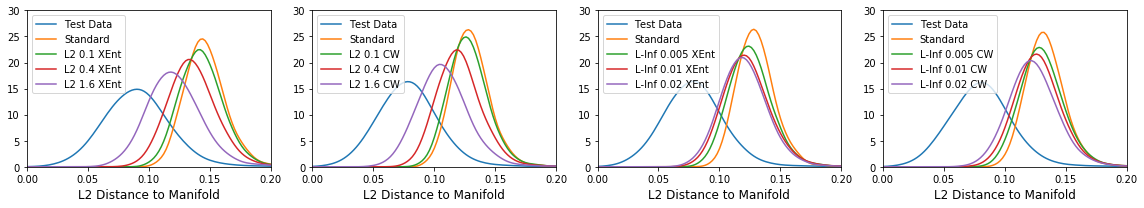

In [3]:
ress = unpickle('results/gradient/exp3/results_cw.pickle')

plt.figure(figsize=(16, 3))

for i, res in enumerate(ress):

    plt.subplot(1, 4, i + 1)

    for j, (name, l2_dist) in enumerate(res[2]):

        if name == 'Test Data':
            xmin = np.min(l2_dist)
            xmax = np.max(l2_dist)

        xs, ys = hist_kde((l2_dist - xmin) / (xmax - xmin), [0.0, 1.0])
        plt.plot(xs, ys, label=name)

    plt.xlim([0.0, 0.2])
    plt.ylim([0, 30])

    plt.xticks(np.arange(0, 0.21, 0.05))

    plt.xlabel('L2 Distance to Manifold', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()

plt.savefig('figs/gradient_cifar10_cw.jpg', bbox_inches='tight', dpi=300)

plt.show()
plt.close()


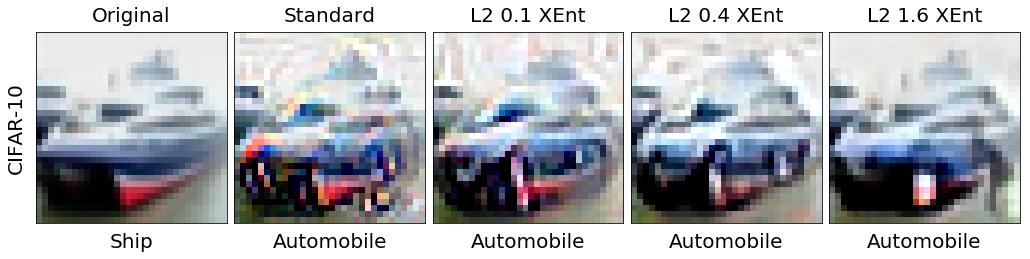

In [181]:
ress = unpickle('results/gradient/exp3/results_xent.pickle')
# ress = unpickle('results/gradient/exp3/results_cw.pickle')

i = 1

plt.figure(figsize=(3 * len(ress[0][0]), 6))

for j, (name, x) in enumerate(ress[0][0]):

    plt.subplot(2, len(ress[0][0]), j + 1)
    plt.imshow((x[i].reshape(32, 32, 3) + 1.0) * 0.5, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('Original' if name == 'Test Data' else name, fontsize=20, pad=10)

    if j == 0:
        plt.xlabel('Ship', fontsize=20, labelpad=10)
    else:
        plt.xlabel('Automobile', fontsize=20, labelpad=10)

    if j == 0:
plt.subplots_adjust(wspace=-0.15, hspace=0.03)

plt.savefig('figs/attack_cifar10.jpg', bbox_inches='tight', dpi=300)

plt.show()
